In [ ]:
from google.colab import drive

drive.mount('/content/drive')
file_path ='/content/drive/My Drive/Dissertation/observation_data.csv'
file_path_golden = '/content/drive/My Drive/Dissertation/golden_dataset_separate_sme_with_comments_preprocessed.csv'
file_path_hardexample = '/content/drive/My Drive/Dissertation/hard_examples.csv'

Mounted at /content/drive


In [ ]:
import ast
import pandas as pd
import numpy as np
import spacy
import re
from collections import Counter
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
from collections import Counter
from nltk.corpus import stopwords
import textstat
import language_tool_python
from textblob import TextBlob
from collections import Counter
from spellchecker import SpellChecker
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import BertForMaskedLM
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer




nltk.download('stopwords')
nltk.download('punkt')


df = pd.read_csv(file_path)
df_golden = pd.read_csv(file_path_golden, encoding='utf-8')
df_hardexample = pd.read_csv(file_path_hardexample)
df_goodexample = df[~df['id'].isin(df_hardexample['id'])]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
!pip install textstat
!pip install language_tool_python
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 28.1 MB/s eta 0:00:00


In [ ]:
pip install --upgrade torch

## 1 Data preprocessing

In [ ]:
#将原始数据转化为列表
def to_list(val):
    if isinstance(val, str):
        try:
            # 使用 ast.literal_eval 安全地解析字符串为列表
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            # 如果解析失败，返回一个空列表
            return []
    elif isinstance(val, list):
        return val
    else:
        # 如果既不是字符串也不是列表，返回一个空列表
        return []

#将safe/unsafe，act/condition，分解为两位专家的标签
def split_safe_unsafe(row):
    if len(row['safe/unsafe']) == 1:
        return [row['safe/unsafe'][0]], [row['safe/unsafe'][0]]
    elif len(row['safe/unsafe']) == 2:
        return [row['safe/unsafe'][0]], [row['safe/unsafe'][1]]
    else:
        return [], []

def split_act_condition(row):
    if len(row['act/condition']) == 1:
        return [row['act/condition'][0]], [row['act/condition'][0]]
    elif len(row['act/condition']) == 2:
        return [row['act/condition'][0]], [row['act/condition'][1]]
    else:
        return [], []

#将两位专家针对不同标签的数据存储到results字典中

# 提取指定列到列表
def extract_column_to_list(df, column_name):
    if column_name in df.columns:
        return df[column_name].to_list()
    else:
        return []
#计算每个标签的cohen kappa系数
def kappa_score(labels_expert1, labels_expert2):
    kappa_scores = []
    mlb = MultiLabelBinarizer()
    mlb.fit(labels_expert1 + labels_expert2)
    labels_expert1_bin = mlb.transform(labels_expert1)
    labels_expert2_bin = mlb.transform(labels_expert2)
    for i in range(labels_expert1_bin.shape[1]):
      kappa = cohen_kappa_score(labels_expert1_bin[:, i], labels_expert2_bin[:, i])
      kappa_scores.append(kappa)
    average_kappa_macro = np.mean(kappa_scores)
    return average_kappa_macro

# 定义函数来计算safetype_score
def calculate_safetype_score(safe_list):
    if len(safe_list) == 1:
        return 1
    else:
        return 0

def calculate_barriertype_score(barrier_list):
    if len(barrier_list) == 1:
        return 1
    else:
        return 0

def calculate_comments_score(comments_list):
    if len(comments_list) != 0:
        return 1
    else:
        return 0

def calculate_hazard_labels_score(row):
    set_x = set(row['hazard_labels_x'])
    set_y = set(row['hazard_labels_y'])

    if set_x and set_y:  # 检查 set_x 和 set_y 是否都不为空
        if set_x & set_y:  # 检查是否有交集
            return 1
        else:
            return 0.75
    elif set_x or set_y:  # 其中有一个为空
        return 0.5
    else:  # 两者均为空
        return 0

def calculate_lsr_labels_score(row):
    set_x = set(row['lsr_labels_x'])
    set_y = set(row['lsr_labels_y'])

    if set_x and set_y:  # 检查 set_x 和 set_y 是否都不为空
        if set_x & set_y:  # 检查是否有交集
            return 1
        else:
            return 0.75
    elif set_x or set_y:  # 其中有一个为空
        return 0.5
    else:  # 两者均为空
        return 0

def calculate_barrier_labels_score(row):
    set_x = set(row['barrier_labels_x'])
    set_y = set(row['barrier_labels_y'])

    if set_x and set_y:  # 检查 set_x 和 set_y 是否都不为空
        if set_x & set_y:  # 检查是否有交集
            return 1
        else:
            return 0.75
    elif set_x or set_y:  # 其中有一个为空
        return 0.5
    else:  # 两者均为空
        return 0

def calculate_hazard_labels_score_binary(row):
    set_x = set(row['hazard_labels_x'])
    set_y = set(row['hazard_labels_y'])
    if set_x & set_y:  # 检查是否有交集
        return 1
    else:
        return 0

def calculate_lsr_labels_score_binary(row):
    set_x = set(row['lsr_labels_x'])
    set_y = set(row['lsr_labels_y'])
    if set_x & set_y:  # 检查是否有交集
        return 1
    else:
        return 0

def calculate_barrier_labels_score_binary(row):
    set_x = set(row['barrier_labels_x'])
    set_y = set(row['barrier_labels_y'])
    if set_x & set_y:  # 检查是否有交集
        return 1
    else:
        return 0

def calculate_overall_score(row):
    safetype_score = row['safetype_score']
    barriertype_score = row['barriertype_score']
    comments_score = row['comments_score']
    hazard_labels_score = row['hazard_labels_score']
    lsr_labels_score = row['lsr_labels_score']
    barrier_labels_score = row['barrier_labels_score']

    # overall_score = (0.30 * safetype_score +
    #                  0.30 * barriertype_score +
    #                  0.25 * comments_score +
    #                  0.05 * (hazard_labels_score + lsr_labels_score + barrier_labels_score))
    # overall_score = (0.50 * safetype_score +
    #               0.50 * barriertype_score +
    #               (-1) * comments_score
    #  )
    overall_score = (0.275 * safetype_score +
                     0.275 * barriertype_score +
                     (-0.45) * comments_score +
                     0.15 * (hazard_labels_score + lsr_labels_score + barrier_labels_score))
    return overall_score
#为每列数据打上质量标签
# def categorize_quality(score):
#     if score == 1:
#         return 'high quality'
#     elif score >= 0.7:
#         return 'medium quality'
#     else:
#         return 'low quality'
def categorize_quality(score):
    if score >= 0.5:
        return 'high quality'
    else:
        return 'low quality'

In [ ]:
#将数据转化为列表
df_golden['safe/unsafe'] = df_golden['safe/unsafe'].apply(to_list)
df_golden['act/condition'] = df_golden['act/condition'].apply(to_list)
df_golden['comments from annotator'] = df_golden['comments from annotator'].apply(to_list)
df_golden['hazard_labels_x'] = df_golden['hazard_labels_x'].apply(to_list)
df_golden['hazard_labels_y'] = df_golden['hazard_labels_y'].apply(to_list)
df_golden['lsr_labels_x'] = df_golden['lsr_labels_x'].apply(to_list)
df_golden['lsr_labels_y'] = df_golden['lsr_labels_y'].apply(to_list)
df_golden['barrier_labels_x'] = df_golden['barrier_labels_x'].apply(to_list)
df_golden['barrier_labels_y'] = df_golden['barrier_labels_y'].apply(to_list)

# 应用函数进行拆分，结果作为列表包含在新列中
df_split_safe = df_golden.apply(lambda row: split_safe_unsafe(row), axis=1, result_type='expand')
df_split_safe.columns = ['safe/unsafe_x', 'safe/unsafe_y']
df_split_act = df_golden.apply(lambda row: split_act_condition(row), axis=1, result_type='expand')
df_split_act.columns = ['act/condition_x', 'act/condition_y']

# 检查是否已存在 'safe/unsafe_x' 和 'safe/unsafe_y' 列，如果不存在则插入
if 'safe/unsafe_x' not in df_golden.columns:
    df_golden.insert(3, 'safe/unsafe_x', df_split_safe['safe/unsafe_x'])

if 'safe/unsafe_y' not in df_golden.columns:
    df_golden.insert(4, 'safe/unsafe_y', df_split_safe['safe/unsafe_y'])


if 'act/condition_x' not in df_golden.columns:
    df_golden.insert(6, 'act/condition_x', df_split_act['act/condition_x'])

if 'act/condition_y' not in df_golden.columns:
    df_golden.insert(7, 'act/condition_y', df_split_act['act/condition_y'])


# 列名列表
columns_to_extract = ['safe/unsafe_x', 'safe/unsafe_y', 'act/condition_x', 'act/condition_y',
                      'hazard_labels_x', 'hazard_labels_y', 'lsr_labels_x', 'lsr_labels_y',
                      'barrier_labels_x', 'barrier_labels_y']

# 提取每列的值到列表
results = {}
for col in columns_to_extract:
    results[col] = extract_column_to_list(df_golden, col)
#计算kappa score
kappa_score_safe_type = kappa_score(results['safe/unsafe_x'],results['safe/unsafe_y'])
kappa_score_act_type = kappa_score(results['act/condition_x'],results['act/condition_y'])
kappa_score_hazard_type = kappa_score(results['hazard_labels_x'],results['hazard_labels_y'])
kappa_score_lsr_type = kappa_score(results['lsr_labels_x'],results['lsr_labels_y'])
kappa_score_barrier_type = kappa_score(results['barrier_labels_x'],results['barrier_labels_y'])


# 应用函数并添加新列'safetype_score'
df_golden['safetype_score'] = df_golden['safe/unsafe'].apply(calculate_safetype_score)
df_golden['barriertype_score'] = df_golden['act/condition'].apply(calculate_barriertype_score)
df_golden['comments_score'] = df_golden['comments from annotator'].apply(calculate_comments_score)
df_golden['hazard_labels_score'] = df_golden.apply(calculate_hazard_labels_score, axis=1)
df_golden['lsr_labels_score'] = df_golden.apply(calculate_lsr_labels_score, axis=1)
df_golden['barrier_labels_score'] = df_golden.apply(calculate_barrier_labels_score, axis=1)
df_golden['overall_score'] = df_golden.apply(calculate_overall_score, axis=1)
df_golden['quality_type'] = df_golden['overall_score'].apply(categorize_quality)
df_golden['binary_hazard_labels_score'] = df_golden.apply(calculate_hazard_labels_score_binary, axis=1)
df_golden['binary_lsr_labels_score'] = df_golden.apply(calculate_lsr_labels_score_binary, axis=1)
df_golden['binary_barrier_labels_score'] = df_golden.apply(calculate_barrier_labels_score_binary, axis=1)


df_golden_sorted = df_golden.sort_values(by='overall_score', ascending=False)
df_high_quality = df_golden_sorted[df_golden_sorted['overall_score'] == 1]
df_medium_quality = df_golden_sorted[(df_golden_sorted['overall_score'] >= 0.7) & (df_golden_sorted['overall_score'] < 1)]
df_low_quality = df_golden_sorted[df_golden_sorted['overall_score'] < 0.7]

In [ ]:
#test
df_golden
df_golden.to_csv('/content/drive/My Drive/Dissertation/golden_score1.csv', index=False)

In [ ]:
#可视化quality
len_high_quality = len(df_high_quality)
len_medium_quality = len(df_medium_quality)
len_low_quality = len(df_low_quality)

labels = ['High Quality', 'Medium Quality', 'Low Quality']
lengths = [len_high_quality, len_medium_quality, len_low_quality]

plt.bar(labels, lengths, color= 'lightblue')

In [ ]:
pd.set_option('display.max_columns', None)
df_golden

#2 Feature engineering
2.1 Word level feature extraction

In [ ]:
# 定义函数进行小写化和tokenize
def tokenize_text(text):

    # 去除换行符
    cleaned_text = text.replace('\n', ' ')
    #去除特殊字符
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)
    # 转换为小写并进行分词
    doc = nlp(cleaned_text.lower())
    tokens = [token.text for token in doc]
    filtered_tokens = [token for token in tokens if token.strip() and token not in custom_stopwords]
    return filtered_tokens

# 定义函数进行词性标注，并计算词性数量
def pos_tagging_and_count(text):
    doc = nlp(text.lower())
    tokens = [token.text for token in doc]
    pos_counts = {'NOUN': 0, 'VERB': 0, 'ADJ': 0, 'ADV': 0}
    pos_tags = []

    for token in doc:
        pos_tags.append((token.text, token.pos_))
        if token.pos_ in pos_counts:
            pos_counts[token.pos_] += 1

    return pos_tags, pos_counts


# 定义函数去除停用词
def remove_stopwords(tokens):
    filtered_tokens = [token for token in tokens if token.lower() not in sklearn_stopwords]
    return filtered_tokens
#计算所有单词出现的次数
def count_word_frequencies(df, column_name):
    """
    计算 DataFrame 指定列中所有单词的出现次数。

    参数:
    df (pd.DataFrame): 包含 tokenized 文本的 DataFrame。
    column_name (str): 包含 tokenized 文本的列名。

    返回:
    pd.DataFrame: 包含每个单词及其出现次数的 DataFrame。
    """
    # 检查列是否存在
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")

    # 提取所有单词到一个列表中
    all_words = [word for sublist in df[column_name] for word in sublist]

    # 计算每个单词出现的次数
    word_counts = Counter(all_words)

    # 转换为 DataFrame 以便于查看
    word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])
    sorted_df = word_counts_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
    return sorted_df

In [ ]:


nltk_stopwords = set(nltk.corpus.stopwords.words('english'))
sklearn_stopwords = set(ENGLISH_STOP_WORDS)
nlp = spacy.load("en_core_web_sm")
custom_stopwords = ['work','good','observed']  # 你可以在这个列表中添加需要删除的单词

# 应用函数并添加新列

df_golden['Tokenized'] = df_golden['observation text'].apply(tokenize_text)
df_golden['PoS_tagged'], pos_counts_list = zip(*df_golden['observation text'].apply(pos_tagging_and_count))
df_golden['Tokenized without stop words'] = df_golden['Tokenized'].apply(remove_stopwords)
df_golden['observation text'] = df_golden['observation text'].str.replace('\n', ' ', regex=False)


word_counts_df = count_word_frequencies(df_golden, 'Tokenized without stop words')
pos_counts_df = pd.DataFrame(pos_counts_list)
df_golden = pd.concat([df_golden, pos_counts_df], axis=1)

2.2 Phrase level feature extraction

In [ ]:
tool = language_tool_python.LanguageTool('en-US')  # 使用适合的语言模型，如'en-US'或其他
# 加载英语模型
nlp = spacy.load("en_core_web_sm")
# 定义函数计算句子数量和单词数量
def calculate_text_metrics(text):
    # 使用nltk分割句子
    sentences = nltk.sent_tokenize(text)
    sentence_count = len(sentences)

    # 使用nltk分割单词
    words = nltk.word_tokenize(text)
    word_count = len(words)

    return sentence_count, word_count

# 定义句子复杂度计算函数
def calculate_sentence_complexity(text):
    # 分词
    words = nltk.word_tokenize(text)
    word_count = len(words)

    # 计算平均词长
    avg_word_length = sum(len(word) for word in words) / word_count

    # 计算句子数量
    sentence_count = len(nltk.sent_tokenize(text))

    # 计算从属子句数量
    doc = nlp(text)
    sub_clauses_count = sum(1 for token in doc if token.dep_ in ["mark", "advcl", "acl", "relcl"])

    # 计算总复杂度评分（可根据实际情况调整权重）
    complexity_score = avg_word_length + (word_count / sentence_count) + sub_clauses_count

    return complexity_score

# 定义函数计算可读性
def calculate_readability(text):
    return textstat.flesch_kincaid_grade(text)

def evaluate_grammar(text):
    if not text:
        return 'Unknown'

    matches = tool.check(text)
    num_errors = len(matches)

    # 返回语法错误的数量或详细描述
    return num_errors

def calculate_lexical_accuracy_textblot(text):
    if not text:
        return pd.Series([0, 0])  # 返回词汇多样性和拼写错误数量的默认值

    # 清理文本，去除标点和小写化
    words = re.findall(r'\b\w+\b', text.lower())

    # 计算Type-Token Ratio (TTR)
    word_count = len(words)
    unique_word_count = len(set(words))
    ttr = unique_word_count / word_count if word_count > 0 else 0

    # 使用 TextBlob 进行拼写检查
    blob = TextBlob(text)
    corrected_text = str(blob.correct())

    # 计算拼写错误数量
    original_words = set(re.findall(r'\b\w+\b', text.lower()))
    corrected_words = set(re.findall(r'\b\w+\b', corrected_text.lower()))
    num_spelling_errors = len(original_words - corrected_words)

    return pd.Series([ttr, num_spelling_errors])

#使用spellchecker 更快
def calculate_lexical_accuracy(text):
    if not text:
        return pd.Series([0, 0])  # 返回词汇多样性和拼写错误数量的默认值

    # 初始化拼写检查器
    spell = SpellChecker()

    # 清理文本，去除标点和小写化
    words = re.findall(r'\b\w+\b', text.lower())

    # 计算Type-Token Ratio (TTR)
    word_count = len(words)
    unique_word_count = len(set(words))
    ttr = unique_word_count / word_count if word_count > 0 else 0

    # 计算拼写错误数量
    misspelled = spell.unknown(words)
    num_spelling_errors = len(misspelled)

    return pd.Series([ttr, num_spelling_errors])

# 加载 BERT 模型和 tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

# 计算文本困惑度的函数
def calculate_perplexity(text):

    inputs = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs['input_ids'])
        loss = outputs.loss
    perplexity = torch.exp(loss).item()
    return perplexity

# 计算主观性评分的函数
def calculate_subjectivity(text):
    blob = TextBlob(text)
    return blob.sentiment.subjectivity

INFO:language_tool_python.download_lt:Unzipping /tmp/tmphu8w0e2p.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://www.languagetool.org/download/LanguageTool-6.4.zip to /root/.cache/language_tool_python.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# 应用函数，并将结果添加到新的列中
df_golden['Sentence Count'], df_golden['Word Count'] = zip(*df_golden['observation text'].apply(calculate_text_metrics))
# 应用函数并添加新列
df_golden['Sentence Complexity'] = df_golden['observation text'].apply(calculate_sentence_complexity)
# 应用函数并添加新列
df_golden['Readability'] = df_golden['observation text'].apply(calculate_readability)
df_golden['grammar_accuracy'] = df_golden['observation text'].apply(evaluate_grammar)
# 将词汇多样性和拼写错误数量添加到数据框中
# df_golden[['lexical_diversity', 'spelling_errors']] = df_golden['observation text'].apply(calculate_lexical_accuracy)
df_golden[['lexical_diversity', 'spelling_errors']] = df_golden['observation text'].apply(calculate_lexical_accuracy)

# 计算每个文本的困惑度，并将结果添加到数据框中 perplexity越低越好
df_golden['perplexity'] = df_golden['observation text'].apply(calculate_perplexity)
# 困惑度越低表示文本越连贯 对perplexity取倒数，使得结果越高越好
df_golden['logical_coherence'] = df_golden['perplexity'].apply(lambda x: 1 / x)  # 更高的逻辑连贯性评分

# 计算主观性
df_golden['subjectivity'] = df_golden['observation text'].apply(calculate_subjectivity)

In [ ]:
#pearson相关系数 计算每个变量与quality type相关性
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_golden['quality_type_encoded'] = label_encoder.fit_transform(df_golden['quality_type'])

features_to_check = [
    'NOUN', 'VERB', 'ADJ', 'ADV', 'Sentence Count', 'Word Count',
    'Sentence Complexity', 'Readability', 'grammar_accuracy',
    'lexical_diversity', 'spelling_errors', 'perplexity',
    'logical_coherence', 'subjectivity'
]
# 计算这些列与 'quality_type' 的相关性
correlation_results = {}
for column in features_to_check:
    correlation = df_golden[column].corr(df_golden['overall_score'])
    correlation_results[column] = correlation

# 将结果转换为数据框
correlation_df = pd.DataFrame(list(correlation_results.items()), columns=['Feature', 'Correlation with Quality Type'])

In [ ]:
pd.set_option('display.max_columns', None)
df_golden
correlation_df

,Feature,Correlation with Quality Type
0,NOUN,0.204406
1,VERB,0.198806
2,ADJ,0.175179
3,ADV,0.092450
4,Sentence Count,0.190869
5,Word Count,0.187520
6,Sentence Complexity,0.092656
7,Readability,0.043406
8,grammar_accuracy,0.087231
9,lexical_diversity,-0.188201


In [ ]:
#点二列相关系数
from scipy.stats import pointbiserialr

continuous_variables = ['NOUN', 'VERB', 'ADJ', 'ADV', 'Sentence Count', 'Word Count',
                        'Sentence Complexity', 'Readability', 'grammar_accuracy',
                        'lexical_diversity', 'spelling_errors', 'perplexity',
                        'logical_coherence', 'subjectivity'

                        #, 'similarity_score_safetype', 'similarity_score_barriertype',
                        # 'similarity_score_comments', 'similarity_score_hazard',
                        # 'similarity_score_lsr', 'similarity_score_barrier'
                        ]

# 保存结果的字典
correlation_results = {}

# 计算每个连续变量与safetype_score之间的点二列相关系数
for var in continuous_variables:
    correlation, p_value = pointbiserialr(df_golden['overall_score'], df_golden[var])
    correlation_results[var] = {'Correlation': correlation, 'p-value': p_value}

# 将结果转换为DataFrame格式以便查看
correlation_df = pd.DataFrame(correlation_results).T

print(correlation_df)

                     Correlation   p-value
NOUN                    0.204406  0.000366
VERB                    0.198806  0.000533
ADJ                     0.175179  0.002326
ADV                     0.092450  0.110037
Sentence Count          0.190869  0.000891
Word Count              0.187520  0.001101
Sentence Complexity     0.092656  0.109243
Readability             0.043406  0.453842
grammar_accuracy        0.087231  0.131693
lexical_diversity      -0.188201  0.001055
spelling_errors         0.119821  0.038063
perplexity             -0.020592  0.722427
logical_coherence       0.216461  0.000158
subjectivity            0.210971  0.000233


# 2.3 Creat word list(Grouped by labels)

step1:生成语料库单词

In [ ]:
def count_labels(df, column_name):
    """
    计算DataFrame中某列的每个标签的出现次数

    参数:
    - df: DataFrame
    - column_name: 需要计算标签频次的列名

    返回:
    - label_counts: Counter对象，包含每个标签的出现次数
    - label_counts_df: DataFrame，包含标签及其出现次数，并按次数排序
    """
    # 展平指定列中的所有标签
    all_labels = [label for sublist in df[column_name] for label in sublist]

    # 计算每个标签的出现次数
    label_counts = Counter(all_labels)

    # 将结果转换为 DataFrame
    label_counts_df = pd.DataFrame(label_counts.items(), columns=['Label', 'Count'])

    # 按出现次数排序
    label_counts_df = label_counts_df.sort_values(by='Count', ascending=False)

    return label_counts, label_counts_df

def aggregate_text_by_labels(df, label_column, text_column):
    """
    根据指定标签列聚合文本列中的内容

    参数:
    - df: DataFrame
    - label_column: 标签列名
    - text_column: 文本列名

    返回:
    - 聚合后的 DataFrame
    """
    # 展开指定列中的所有标签
    df_exploded = df.explode(label_column)

    # 按标签聚合文本
    # grouped_texts = df_exploded.groupby(label_column)[text_column].apply(lambda x: ' '.join(x)).reset_index()
    # grouped_texts = df_exploded.groupby(label_column)[text_column].apply(lambda x: list(x)).tolist()
    grouped_texts = df_exploded.groupby(label_column)[text_column].apply(lambda x: list(x)).reset_index()


    return grouped_texts
def count_word_frequencies_for_each_row(row, text_column):
    """
    计算每一行文本中的不重复单词及其出现次数，并返回一个字典。

    参数:
    - row: DataFrame 的一行
    - text_column: 包含文本的列名

    返回:
    - dict: 包含每个单词及其出现次数的字典
    """
    text = row[text_column]
    word_counts = Counter(text)
    return dict(word_counts)

def process_dataframe_with_word_counts(df, text_column):
    """
    对 DataFrame 中每一行的指定文本列计算词频，并将结果添加到一个新的列中。

    参数:
    - df: DataFrame
    - text_column: 包含文本的列名

    返回:
    - DataFrame: 包含词频字典的新列
    """
    # 应用函数到每一行
    df['Word_Frequencies'] = df.apply(lambda row: count_word_frequencies_for_each_row(row, text_column), axis=1)
    return df

def process_dataframe(df, text_column):
    """对 DataFrame 进行标记化、词性标注、去除停用词及计算词频"""
    df['Tokenized'] = df[text_column].apply(tokenize_text)
    df['PoS_tagged'], pos_counts_list = zip(*df[text_column].apply(pos_tagging_and_count))
    df['Tokenized without stop words'] = df['Tokenized'].apply(remove_stopwords)

    # 计算词频
    word_counts_df = count_word_frequencies(df, 'Tokenized without stop words')
    pos_counts_df = pd.DataFrame(pos_counts_list).fillna(0).astype(int)

    # df['Word_Frequencies'] = df.apply(lambda row: count_word_frequencies_for_each_row(row, text_column), axis=1)
    # 将词性标签频率 DataFrame 合并到原 DataFrame
    df = pd.concat([df, pos_counts_df], axis=1)

    return df, word_counts_df
def count_word_frequencies_2(text_list):
    """
    计算文本中的每个单词及其出现次数，并返回一个字典。

    参数:
    - text_list: 包含单词的列表

    返回:
    - dict: 包含每个单词及其出现次数的字典
    """
    word_counts = Counter(text_list)
    return dict(word_counts)

def sort_word_frequencies(word_freq_dict):
    """
    对词频字典按单词出现次数从高到低排序，并返回排序后的列表。

    参数:
    - word_freq_dict: 包含单词及其出现次数的字典

    返回:
    - list: 按出现次数排序的 (单词, 频次) 元组列表
    """
    sorted_word_freq = sorted(word_freq_dict.items(), key=lambda item: item[1], reverse=True)
    return sorted_word_freq


def extract_keywords_with_tfidf(dataframe, text_column, stop_words='english', threshold=0.05):
    """
    计算DataFrame中文本列的TF-IDF值，并提取每个文档的关键词及其分数。

    参数:
    - dataframe: 包含文本数据的DataFrame
    - text_column: 包含文本的列名
    - stop_words: 停用词设置（默认值为'english'）
    - threshold: 提取关键词的TF-IDF值的阈值（默认为0.05）

    返回:
    - tfidf_df: 包含TF-IDF值的DataFrame
    - top_keywords_list: 每个文档的关键词及其分数列表
    """
    # 初始化TfidfVectorizer
    vectorizer = TfidfVectorizer(stop_words=stop_words)

    # 计算TF-IDF矩阵
    tfidf_matrix = vectorizer.fit_transform(dataframe[text_column])

    # 提取特征名称（即词汇表）
    feature_names = vectorizer.get_feature_names_out()

    # 将TF-IDF矩阵转换为DataFrame，以便查看结果
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

    # 提取每个文档的关键词及其分数
    top_keywords_list = []
    for row in tfidf_matrix.toarray():
        top_keywords_list.append(get_top_keywords_with_scores(row, feature_names, threshold=threshold))

    return tfidf_df, top_keywords_list

def get_top_keywords_with_scores(tfidf_row, features, threshold=0.05):
    """
    返回 TF-IDF 值大于给定阈值的关键词及其分数。

    参数:
    - tfidf_row: 一个包含 TF-IDF 值的向量。
    - features: 特征名称（即关键词）。
    - threshold: 过滤关键词的 TF-IDF 阈值，默认值为 0.05。

    返回:
    - 关键词及其对应 TF-IDF 分数的列表，过滤掉 TF-IDF 分数低于阈值的词。
    """
    # 过滤出 TF-IDF 值大于阈值的关键词及其分数
    keywords_with_scores = [(features[i], tfidf_row[i]) for i in range(len(features)) if tfidf_row[i] > threshold]

    # 按照分数降序排列
    sorted_keywords_with_scores = sorted(keywords_with_scores, key=lambda x: x[1], reverse=True)

    return sorted_keywords_with_scores

def save_keywords_to_txt(keywords_list, file_name):
    """
    将关键词列表保存到文本文件中。

    参数:
    - keywords_list: 包含多个子列表的列表，每个子列表包含若干元组，元组的第一个元素为关键词
    - file_name: 输出的文件名
    """
    with open(file_name, 'w') as file:
        for sublist in keywords_list:
            # 提取每个元组的第一个元素（关键词）并拼接成一句话
            keywords = [item[0] for item in sublist]
            line = ' '.join(keywords)
            file.write(line + '\n')

In [ ]:
#Method 1 ：按词频生成语料库
#step1 合并标签
df_golden['hazard_labels'] = df_golden.apply(lambda row: list(set(row['hazard_labels_x'] + row['hazard_labels_y'])), axis=1)
df_golden['lsr_labels'] = df_golden.apply(lambda row: list(set(row['lsr_labels_x'] + row['lsr_labels_y'])), axis=1)
df_golden['barrier_labels'] = df_golden.apply(lambda row: list(set(row['barrier_labels_x'] + row['barrier_labels_y'])), axis=1)

cols = list(df_golden.columns)
# 将 hazard_labels 列插入到 hazard_labels_y 列的后面
index = cols.index('hazard_labels_y')  # 获取 hazard_labels_y 列的位置
cols.insert(index + 1, cols.pop(cols.index('hazard_labels')))  # 将 hazard_labels 插入到 hazard_labels_y 后面
# 插入 lsr_labels 列到 lsr_labels_y 列后面
index_lsr = cols.index('lsr_labels_y')
cols.insert(index_lsr + 1, cols.pop(cols.index('lsr_labels')))
# 插入 barrier_labels 列到 barrier_labels_y 列后面
index_barrier = cols.index('barrier_labels_y')
cols.insert(index_barrier + 1, cols.pop(cols.index('barrier_labels')))

df_golden = df_golden[cols]

#step2 按照标签进行分类
#1）找到所有不重复的标签
unique_hazard_labels = set(label for sublist in df_golden['hazard_labels'] for label in sublist)
unique_lsr_labels = set(label for sublist in df_golden['lsr_labels'] for label in sublist)
unique_barrier_labels = set(label for sublist in df_golden['barrier_labels'] for label in sublist)
#2）对label类型进行统计
# # lsr_labels 统计
# lsr_label_counts, lsr_label_counts_df = count_labels(df_golden, 'lsr_labels')
# print("LSR Labels Count:")
# print(lsr_label_counts_df)

# # hazard_labels 统计
# hazard_label_counts, hazard_label_counts_df = count_labels(df_golden, 'hazard_labels')
# print("Hazard Labels Count:")
# print(hazard_label_counts_df)

# # barrier_labels 统计
# barrier_label_counts, barrier_label_counts_df = count_labels(df_golden, 'barrier_labels')
# print("Barrier Labels Count:")
# print(barrier_label_counts_df)
#3）将每一类标签展开、聚合
# 对 lsr_labels 列进行操作
grouped_df_lsr = aggregate_text_by_labels(df_golden, 'lsr_labels', 'observation text')
# 对 hazard_labels 列进行操作
grouped_df_hazard = aggregate_text_by_labels(df_golden, 'hazard_labels', 'observation text')
# 对 barrier_labels 列进行操作
grouped_df_barrier = aggregate_text_by_labels(df_golden, 'barrier_labels', 'observation text')

grouped_df_hazard = grouped_df_hazard.rename(columns={'observation text': 'observation text to list'})
grouped_df_lsr = grouped_df_lsr.rename(columns={'observation text': 'observation text to list'})
grouped_df_barrier = grouped_df_barrier.rename(columns={'observation text': 'observation text to list'})

grouped_df_lsr['observation text'] = grouped_df_lsr['observation text to list'].apply(lambda x: ' '.join(x))
grouped_df_hazard['observation text'] = grouped_df_hazard['observation text to list'].apply(lambda x: ' '.join(x))
grouped_df_barrier['observation text'] = grouped_df_barrier['observation text to list'].apply(lambda x: ' '.join(x))
# 4）对聚合后的文本进行分词等预处理操作
grouped_df_lsr, word_counts_df_lsr = process_dataframe(grouped_df_lsr, 'observation text')
grouped_df_barrier, word_counts_df_barrier = process_dataframe(grouped_df_barrier, 'observation text')
grouped_df_hazard, word_counts_df_hazard = process_dataframe(grouped_df_hazard, 'observation text')

grouped_df_lsr['Word_Frequencies'] = grouped_df_lsr['Tokenized without stop words'].apply(count_word_frequencies_2)
grouped_df_lsr['Sorted_Word_Frequencies'] = grouped_df_lsr['Word_Frequencies'].apply(sort_word_frequencies)

grouped_df_barrier['Word_Frequencies'] = grouped_df_barrier['Tokenized without stop words'].apply(count_word_frequencies_2)
grouped_df_barrier['Sorted_Word_Frequencies'] = grouped_df_barrier['Word_Frequencies'].apply(sort_word_frequencies)

grouped_df_hazard['Word_Frequencies'] = grouped_df_hazard['Tokenized without stop words'].apply(count_word_frequencies_2)
grouped_df_hazard['Sorted_Word_Frequencies'] = grouped_df_hazard['Word_Frequencies'].apply(sort_word_frequencies)

In [ ]:
#Method 2： 按照TFIDF生成语料库
tfidf_df_hazard, top_keywords_list_hazard = extract_keywords_with_tfidf(grouped_df_hazard, 'observation text')
tfidf_df_lsr, top_keywords_list_lsr = extract_keywords_with_tfidf(grouped_df_lsr, 'observation text')
tfidf_df_barrier, top_keywords_list_barrier = extract_keywords_with_tfidf(grouped_df_barrier, 'observation text')

#将关键词保存到文本文件
# file_name_barrier = '/content/drive/My Drive/Dissertation/top_keywords_list_barrier.txt'
# file_name_lsr = '/content/drive/My Drive/Dissertation/top_keywords_list_lsr.txt'
# file_name_hazard = '/content/drive/My Drive/Dissertation/top_keywords_list_hazard.txt'

# save_keywords_to_txt(top_keywords_list_barrier, file_name_barrier)
# save_keywords_to_txt(top_keywords_list_lsr, file_name_lsr)
# save_keywords_to_txt(top_keywords_list_hazard, file_name_hazard)

In [ ]:
df_golden
top_keywords_list_hazard
grouped_df_hazard
tfidf_df_hazard
len(top_keywords_list_hazard)
top_keywords_list_hazard
grouped_df_hazard
# hazard_labels_dict = grouped_df_hazard['hazard_labels'].to_dict()
# hazard_labels_dict
top_keywords_list_hazard

[[('defenders', 0.267189020720187),
  ('ear', 0.267189020720187),
  ('helicopter', 0.20432175491163534),
  ('passengers', 0.20039176554014024),
  ('locker', 0.1532413161837265),
  ('msds', 0.1532413161837265),
  ('mask', 0.13806226184933318),
  ('bowl', 0.1335945103600935),
  ('disembarking', 0.1335945103600935),
  ('feces', 0.1335945103600935),
  ('boot', 0.11520701384965748),
  ('covid', 0.11520701384965748),
  ('segregation', 0.11520701384965748),
  ('toilets', 0.11520701384965748),
  ('towel', 0.11520701384965748),
  ('tr', 0.11520701384965748),
  ('hygiene', 0.10216087745581767),
  ('toilet', 0.10216087745581767),
  ('clean', 0.09204150789955544),
  ('followed', 0.09204150789955544),
  ('sheets', 0.09204150789955544),
  ('accommodation', 0.08377338094538166),
  ('pipework', 0.08377338094538166),
  ('tagged', 0.08377338094538166),
  ('ops', 0.07850962206165875),
  ('task', 0.07850962206165875),
  ('wcc', 0.07850962206165875),
  ('biocide', 0.07678277921239872),
  ('fit', 0.07678277

2.4 Calculate text similarity

In [ ]:
pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
from bertopic import BERTopic
from transformers.pipelines import pipeline
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction import text

from sklearn.metrics.pairwise import cosine_similarity

def compute_bert_embeddings(file_name, model_name="bert-base-uncased", batch_size=16):
    """
    计算文本的BERT CLS嵌入向量

    参数:
    - file_name: 包含文本数据的文件路径
    - model_name: 预训练BERT模型的名称
    - batch_size: 数据批次大小

    返回:
    - cls_embeddings_np: 文本的CLS嵌入向量（numpy数组）
    """
    # 加载文本数据
    with open(file_name, 'r') as file:
        docs = [line.strip() for line in file.readlines()]

    # 初始化BERT模型和tokenizer
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)

    # 将模型移动到CPU/GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # 创建数据加载器
    data_loader = DataLoader(docs, batch_size=batch_size, shuffle=False)

    # 计算CLS嵌入
    cls_embeddings = []
    for batch_sentences in tqdm(data_loader):
        inputs = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt", max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embeddings.append(outputs.last_hidden_state[:, 0].cpu().numpy())  # 只取CLS对应的向量

    # 堆叠所有CLS嵌入
    cls_embeddings_np = np.vstack(cls_embeddings)

    return cls_embeddings_np

def find_top_n_similar_sentences_with_scores(embeddings, embeddings_lsr, top_n=3):
    """
    计算每个句子与给定句子集合的相似度，并找到相似度最高的前 top_n 个句子及其索引和分数。

    参数:
    - embeddings: (300, 768) 数组，包含300个句子的嵌入
    - embeddings_lsr: (9, 768) 数组，包含9个句子的嵌入
    - top_n: 需要返回的相似度最高的句子的数量

    返回:
    - indices: (300, top_n) 数组，每行包含每个句子与给定句子集合中最相似的 top_n 个句子的索引
    - scores: (300, top_n) 数组，每行包含每个句子与给定句子集合中最相似的 top_n 个句子的相似度分数
    """
    # 计算余弦相似度
    similarity_matrix = cosine_similarity(embeddings, embeddings_lsr)

    # 找到每个句子与给定句子集合中相似度最高的前 top_n 个句子及其索引和分数
    top_n_indices = np.argsort(-similarity_matrix, axis=1)[:, :top_n]
    top_n_scores = np.take_along_axis(similarity_matrix, top_n_indices, axis=1)

    return top_n_indices, top_n_scores

def find_most_similar_sentences_with_scores(embeddings, embeddings_lsr):
    """
    计算每个句子与给定句子集合的相似度，并找到相似度最高的句子及其索引和分数。

    参数:
    - embeddings: (300, 768) 数组，包含300个句子的嵌入
    - embeddings_lsr: (9, 768) 数组，包含9个句子的嵌入

    返回:
    - indices: (300,) 数组，包含每个句子与给定句子集合中相似度最高的句子索引
    - scores: (300,) 数组，包含每个句子与给定句子集合中相似度最高的相似度分数
    """
    # 计算余弦相似度
    similarity_matrix = cosine_similarity(embeddings, embeddings_lsr)

    # 找到每个句子与给定句子集合中相似度最高的句子及其索引和分数
    indices = np.argmax(similarity_matrix, axis=1)
    scores = np.max(similarity_matrix, axis=1)

    return indices, scores

file_name = '/content/drive/My Drive/Dissertation/golden_observations.txt'
with open(file_name, 'r') as file:
  # docs = file.readlines()
  docs = [line.strip() for line in file.readlines()]

In [ ]:
#1.使用bert进行embedding（或者使用word2vec进行embedding，后续加入进来）

#1)加载模型，划分batch，将所有句子进行向量化表示


file_name = '/content/drive/My Drive/Dissertation/golden_observations.txt'
file_name_lsr = '/content/drive/My Drive/Dissertation/top_keywords_list_lsr.txt'
file_name_barrier = '/content/drive/My Drive/Dissertation/top_keywords_list_barrier.txt'
file_name_hazard = '/content/drive/My Drive/Dissertation/top_keywords_list_hazard.txt'

embeddings = compute_bert_embeddings(file_name)
embeddings_lsr = compute_bert_embeddings(file_name_lsr,batch_size=5)
embeddings_barrier = compute_bert_embeddings(file_name_barrier,batch_size=5)
embeddings_hazard = compute_bert_embeddings(file_name_hazard,batch_size=5)

#2）计算文本与每一类别的相似度，输出相似度分数
# top_indices, top_scores = find_top_n_similar_sentences_with_scores(embeddings, embeddings_hazard, top_n=3)
most_similar_indices, similarity_scores = find_most_similar_sentences_with_scores(embeddings, embeddings_hazard)

hazard_labels_dict = grouped_df_hazard['hazard_labels'].to_dict()
lsr_labels_dict = grouped_df_lsr['lsr_labels'].to_dict()
barrier_labels_dict = grouped_df_barrier['barrier_labels'].to_dict()
# 打印结果
# for i in range(len(top_indices)):
#     print(f"Sentence {i}:")
#     for j in range(3):  # top_n = 3
#         index = top_indices[i, j]
#         score = top_scores[i, j]
#         print(f"  Most similar to sentence {hazard_labels_dict[index]} with a score of {score:.4f}")

# 打印结果
for i, (index, score) in enumerate(zip(most_similar_indices, similarity_scores)):
    print(f"Sentence {i}: Most similar to sentence {hazard_labels_dict[index]} with a score of {score:.4f}")

100%|██████████| 3/3 [00:05<00:00,  1.88s/it]

Sentence 0: Most similar to sentence Temperature with a score of 0.8053
Sentence 1: Most similar to sentence Pressure with a score of 0.8043
Sentence 2: Most similar to sentence Pressure with a score of 0.7778
Sentence 3: Most similar to sentence Gravity with a score of 0.8155
Sentence 4: Most similar to sentence Safety Systems with a score of 0.8340
Sentence 5: Most similar to sentence Chemical with a score of 0.7807
Sentence 6: Most similar to sentence Safety Systems with a score of 0.7583
Sentence 7: Most similar to sentence Temperature with a score of 0.6399
Sentence 8: Most similar to sentence Chemical with a score of 0.7704
Sentence 9: Most similar to sentence Chemical with a score of 0.8636
Sentence 10: Most similar to sentence Pressure with a score of 0.8037
Sentence 11: Most similar to sentence Pressure with a score of 0.8296
Sentence 12: Most similar to sentence Chemical with a score of 0.7646
Sentence 13: Most similar to sentence Pressure with a score of 0.5558
Sentence 14: 

In [ ]:
#2）计算文本与每一类别的相似度，输出相似度分数

most_similar_indices_hazard, similarity_scores_hazard = find_most_similar_sentences_with_scores(embeddings, embeddings_hazard)
most_similar_indices_lsr, similarity_scores_lsr = find_most_similar_sentences_with_scores(embeddings, embeddings_lsr)
most_similar_indices_barrier, similarity_scores_barrier = find_most_similar_sentences_with_scores(embeddings, embeddings_barrier)

hazard_labels_dict = grouped_df_hazard['hazard_labels'].to_dict()
lsr_labels_dict = grouped_df_lsr['lsr_labels'].to_dict()
barrier_labels_dict = grouped_df_barrier['barrier_labels'].to_dict()


# 打印结果
# for i, (index, score) in enumerate(zip(most_similar_indices, similarity_scores)):
#     print(f"Sentence {i}: Most similar to sentence {hazard_labels_dict[index]} with a score of {score:.4f}")
len(similarity_scores)
similarity_scores_lsr
lsr_labels_dict

{0: 'Bypassing Safety Control',
 1: 'Confined Space',
 2: 'Driving',
 3: 'Energy Isolation',
 4: 'Hot Work',
 5: 'Line of Fire',
 6: 'Safe Mechanical Lifting',
 7: 'Work Authorisation',
 8: 'Working at Height'}

In [ ]:
grouped_df_hazard

,hazard_labels,observation text to list,observation text,Tokenized,PoS_tagged,Tokenized without stop words,NOUN,VERB,ADJ,ADV,Word_Frequencies,Sorted_Word_Frequencies
0,Biological,"[Whilst answering natures call, it became appa...","Whilst answering natures call, it became appar...","[whilst, answering, natures, call, it, became,...","[(whilst, SCONJ), (answering, VERB), (natures,...","[whilst, answering, natures, apparent, toilet,...",164,87,38,11,"{'whilst': 1, 'answering': 1, 'natures': 1, 'a...","[(helicopter, 4), (eardefenders, 4), (used, 3)..."
1,Chemical,[Observed team member de-canting oil from Mud ...,Observed team member de-canting oil from Mud p...,"[team, member, decanting, oil, from, mud, pump...","[(observed, VERB), (team, NOUN), (member, NOUN...","[team, member, decanting, oil, mud, pumps, per...",906,405,180,74,"{'team': 15, 'member': 2, 'decanting': 2, 'oil...","[(tank, 28), (op, 18), (team, 15), (gas, 15), ..."
2,Electrical,[Observed man replacing junction box on PA sys...,Observed man replacing junction box on PA syst...,"[man, replacing, junction, box, on, pa, system...","[(observed, VERB), (man, NOUN), (replacing, VE...","[man, replacing, junction, box, pa, drill, rig...",248,125,49,17,"{'man': 2, 'replacing': 1, 'junction': 3, 'box...","[(op, 11), (isolation, 9), (correct, 8), (work..."
3,Environment,"[Whilst answering natures call, it became appa...","Whilst answering natures call, it became appar...","[whilst, answering, natures, call, it, became,...","[(whilst, SCONJ), (answering, VERB), (natures,...","[whilst, answering, natures, apparent, toilet,...",274,121,66,26,"{'whilst': 1, 'answering': 1, 'natures': 1, 'a...","[(deck, 8), (waste, 6), (team, 5), (oil, 5), (..."
4,Gravity,[Observed man replacing junction box on PA sys...,Observed man replacing junction box on PA syst...,"[man, replacing, junction, box, on, pa, system...","[(observed, VERB), (man, NOUN), (replacing, VE...","[man, replacing, junction, box, pa, drill, rig...",1109,527,208,84,"{'man': 12, 'replacing': 1, 'junction': 2, 'bo...","[(deck, 21), (noticed, 19), (lift, 16), (equip..."
5,Human Factors,"[Whilst answering natures call, it became appa...","Whilst answering natures call, it became appar...","[whilst, answering, natures, call, it, became,...","[(whilst, SCONJ), (answering, VERB), (natures,...","[whilst, answering, natures, apparent, toilet,...",2190,1009,489,173,"{'whilst': 21, 'answering': 1, 'natures': 1, '...","[(team, 39), (op, 36), (tank, 32), (area, 31),..."
6,Major Accident Hazards,"[Observed Area Operator carrying out a Gas, Be...","Observed Area Operator carrying out a Gas, Ben...","[area, operator, carrying, out, a, gas, benzen...","[(observed, VERB), (area, NOUN), (operator, NO...","[area, operator, carrying, gas, benzene, mercu...",636,290,147,72,"{'area': 8, 'operator': 4, 'carrying': 8, 'gas...","[(op, 15), (gas, 12), (equipment, 12), (notice..."
7,Mechanical,[Utilised as a sub-standard report! Observe...,Utilised as a sub-standard report! Observed...,"[utilised, as, a, substandard, report, drain, ...","[(utilised, VERB), (as, ADP), (a, DET), (sub, ...","[utilised, substandard, report, drain, cover, ...",1237,596,267,89,"{'utilised': 5, 'substandard': 3, 'report': 6,...","[(forklift, 24), (noticed, 20), (place, 19), (..."
8,Pressure,[Observed breaking containment activities on P...,Observed breaking containment activities on PS...,"[breaking, containment, activities, on, psv, r...","[(observed, VERB), (breaking, VERB), (containm...","[breaking, containment, activities, psv, repla...",307,135,48,27,"{'breaking': 2, 'containment': 2, 'activities'...","[(gas, 9), (valve, 6), (carrying, 5), (prior, ..."
9,Radiation,[Good use of barriers to restrict access into ...,Good use of barriers to restrict access into w...,"[use, of, barriers, to, restrict, access, into...","[(good, ADJ), (use, NOUN), (of, ADP), (barrier...","[use, barriers, restrict, access, area, radiog...",149,68,27,9,"{'use': 2, 'barriers': 5, 'restrict': 1, '

In [ ]:
#使用TFIDF编码计算相似度
def create_keywords_dict(labels_dict, file_path_barrier):
    """
    创建一个字典，将 barrier_labels_dict 中的每个标签映射到 file_path_barrier 文件中对应的单词列表。

    :param barrier_labels_dict: 包含标签和主题的字典，格式为 {'label': 'theme'}
    :param file_path_barrier: 文件路径，包含关键词列表，每行一个列表
    :return: barrier_keywords_dict，字典的键为主题，值为对应的单词列表
    """
    keywords_dict = {}
    texts = []

    # 读取文件并处理每一行
    with open(file_path_barrier, 'r', encoding='utf-8') as file:
        for line in file:
            # 去掉行末的换行符，并将每行拆分成单词列表
            words = line.strip().split()
            # 将单词列表添加到 barrier_texts 中
            texts.append(words)

    # 构建新的字典
    for label, theme in labels_dict.items():
        # 获取 barrier_texts 中的索引（假设与 barrier_labels_dict 的顺序对应）
        index = list(labels_dict.keys()).index(label)

        if index < len(texts):
            # 将 barrier_texts 中的列表作为值，添加到新字典中
            keywords_dict[theme] = texts[index]
        else:
            # 如果 barrier_texts 中没有足够的列表，则使用空列表或其他默认值
            keywords_dict[theme] = []

    return keywords_dict

file_path = '/content/drive/My Drive/Dissertation/golden_observations.txt'
file_path_lsr = '/content/drive/My Drive/Dissertation/top_keywords_list_lsr.txt'
file_path_hazard = '/content/drive/My Drive/Dissertation/top_keywords_list_hazard.txt'
file_path_barrier = '/content/drive/My Drive/Dissertation/top_keywords_list_barrier.txt'
file_path = '/content/drive/My Drive/Dissertation/golden_observations.txt'

# 初始化一个空列表来存储每一行
observation_texts = []

# 读取文件并存储每一行
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        # 去掉行末的换行符并添加到列表中
        observation_texts.append(line.strip())

barrier_keywords_dict = create_keywords_dict(barrier_labels_dict, file_path_barrier)
lsr_keywords_dict = create_keywords_dict(lsr_labels_dict, file_path_lsr)
hazard_keywords_dict = create_keywords_dict(hazard_labels_dict, file_path_hazard)

len(observation_texts)

300

In [ ]:
lsr_keywords_dict
hazard_labels_dict
hazard_keywords_dict

{'Biological': ['defenders',
  'ear',
  'helicopter',
  'passengers',
  'locker',
  'msds',
  'mask',
  'bowl',
  'disembarking',
  'feces',
  'boot',
  'covid',
  'segregation',
  'toilets',
  'towel',
  'tr',
  'hygiene',
  'toilet',
  'clean',
  'followed',
  'sheets',
  'accommodation',
  'pipework',
  'tagged',
  'ops',
  'task',
  'wcc',
  'biocide',
  'fit',
  'room',
  'used',
  'good',
  'observed',
  'op',
  'use',
  'admin',
  'delay',
  'demonstrating',
  'doesn',
  'elses',
  'frustration',
  'handed',
  'lifejackets',
  'makes',
  'mobbing',
  'mother',
  'occasions',
  'policy',
  'practices',
  'retrieve',
  'scrubbing',
  'sent',
  'sewage',
  'sick',
  'surfaces',
  'touching',
  'uncontaminated',
  'water',
  'personnel',
  '19',
  'accomodation',
  'ahu',
  'bins',
  'configured',
  'cotton',
  'covers',
  'damp',
  'evidently',
  'extensively',
  'extract',
  'gross',
  'helideck',
  'looking',
  'medic',
  'mode',
  'occupants',
  'odour',
  'oim',
  'ones',
  'pi

In [ ]:
pd.set_option('display.max_colwidth', 120)
df_lsr_keywords = pd.DataFrame({
    'lsr_keywords': pd.Series(lsr_keywords_dict),
   })
df_hazard_keywords = pd.DataFrame({
    'hazard_keywords': pd.Series(hazard_keywords_dict),
   })
df_barrier_keywords = pd.DataFrame({
    'barrier_keywords': pd.Series(barrier_keywords_dict),
   })
df_hazard_keywords

,hazard_keywords
Biological,"[defenders, ear, helicopter, passengers, locker, msds, mask, bowl, disembarking, feces, boot, covid, segregation, to..."
Chemical,"[tank, work, gas, observed, op, entry, team, good, oil, rescue, equipment, wcc, cse, carrying, area, place, worksite..."
Electrical,"[isolation, op, cable, electrical, worksite, correct, drive, edb, equipment, task, forward, box, junction, drives, c..."
Environment,"[deck, oil, drop, good, waste, tank, protection, noted, skip, tbt, team, double, drain, noticed, recent, segregation..."
Gravity,"[observed, good, forklift, work, lift, deck, lifting, noticed, access, container, fall, team, crane, scaffold, carry..."
Human Factors,"[work, good, observed, team, tank, op, task, area, equipment, forklift, carrying, place, party, scope, correct, used..."
Major Accident Hazards,"[gas, op, software, key, equipment, noticed, mechanical, work, dbb, master, checks, carrying, stored, alarms, meters..."
Mechanical,"[forklift, work, lift, noticed, good, observed, place, task, deck, equipment, truck, container, mounting, sack, stor..."
Pressure,"[gas, key, dbb, master, flange, valve, good, work, interlock, closed, hose, connection, regulator, psv, signed, fitt..."
Radiation,"[radiography, norm, radiation, barriers, proposed, sources, areas, source, address, email, pointed, rps, locations, ..."


In [ ]:
# #使用TFIDF编码计算相似度

# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# import numpy as np
# def find_most_relevant_themes(observation_texts, barrier_keywords_dict):
#     """
#     计算每个 observation_text 与 barrier_keywords_dict 中每个主题的相似度，
#     并找到最相关的主题及其相似度分数。

#     :param observation_texts: List of observation texts
#     :param barrier_keywords_dict: Dictionary where keys are theme names and values are lists of keywords
#     :return: None (prints the most relevant theme and similarity score for each observation text)
#     """
#     # 构建 TF-IDF 向量化器
#     vectorizer = TfidfVectorizer()

#     # 为 observation texts 和主题关键词构建特征矩阵
#     texts_matrix = vectorizer.fit_transform(observation_texts)
#     themes_matrix = vectorizer.transform([" ".join(keywords) for keywords in barrier_keywords_dict.values()])

#     # 计算每行 observation text 与每个主题的相似度
#     similarity_scores = cosine_similarity(texts_matrix, themes_matrix)

#     # 找到每个 observation text 最相关的主题
#     most_relevant_themes = np.argmax(similarity_scores, axis=1)
#     most_relevant_scores = np.max(similarity_scores, axis=1)



#     # 打印每行 observation text 对应的主题及其相似度
#     for i, theme_index in enumerate(most_relevant_themes):
#         theme = list(barrier_keywords_dict.keys())[theme_index]
#         score = most_relevant_scores[i]
#         print(f"Observation text {i+1} is most related to theme '{theme}' with a similarity score of {score:.4f}")
#     return most_relevant_scores, most_relevant_themes

# similarity_score_TFIDF_lsr, relevant_themes_TFIDF_lsr = find_most_relevant_themes(observation_texts, lsr_keywords_dict)
# similarity_score_TFIDF_hazard, relevant_themes_TFIDF_hazard = find_most_relevant_themes(observation_texts, hazard_keywords_dict)
# similarity_score_TFIDF_barrier, relevant_themes_TFIDF_barrier = find_most_relevant_themes(observation_texts, barrier_keywords_dict)


Observation text 1 is most related to theme 'Line of Fire' with a similarity score of 0.0149
Observation text 2 is most related to theme 'Bypassing Safety Control' with a similarity score of 0.0476
Observation text 3 is most related to theme 'Line of Fire' with a similarity score of 0.2222
Observation text 4 is most related to theme 'Line of Fire' with a similarity score of 0.1246
Observation text 5 is most related to theme 'Hot Work' with a similarity score of 0.3792
Observation text 6 is most related to theme 'Safe Mechanical Lifting' with a similarity score of 0.0306
Observation text 7 is most related to theme 'Work Authorisation' with a similarity score of 0.2247
Observation text 8 is most related to theme 'Work Authorisation' with a similarity score of 0.1695
Observation text 9 is most related to theme 'Line of Fire' with a similarity score of 0.1015
Observation text 10 is most related to theme 'Confined Space' with a similarity score of 0.1939
Observation text 11 is most related 

In [ ]:
#使用TFIDF编码计算相似度

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def find_most_relevant_themes(observation_texts, barrier_keywords_dict):
    """
    计算每个 observation_text 与 barrier_keywords_dict 中每个主题的相似度，
    并找到最相关的主题及其相似度分数。

    :param observation_texts: List of observation texts
    :param barrier_keywords_dict: Dictionary where keys are theme names and values are lists of keywords
    :return: most_relevant_scores, most_relevant_themes (similarity scores and corresponding theme names)
    """
    # 构建 TF-IDF 向量化器
    vectorizer = TfidfVectorizer()

    # 为 observation texts 和主题关键词构建特征矩阵
    texts_matrix = vectorizer.fit_transform(observation_texts)
    themes_matrix = vectorizer.transform([" ".join(keywords) for keywords in barrier_keywords_dict.values()])

    # 计算每行 observation text 与每个主题的相似度
    similarity_scores = cosine_similarity(texts_matrix, themes_matrix)

    # 找到每个 observation text 最相关的主题
    most_relevant_indices = np.argmax(similarity_scores, axis=1)
    most_relevant_scores = np.max(similarity_scores, axis=1)

    # 根据索引获取主题名称
    theme_names = list(barrier_keywords_dict.keys())
    most_relevant_themes = [theme_names[index] for index in most_relevant_indices]

    # 打印每行 observation text 对应的主题及其相似度
    for i, theme in enumerate(most_relevant_themes):
        score = most_relevant_scores[i]
        print(f"Observation text {i+1} is most related to theme '{theme}' with a similarity score of {score:.4f}")

    return most_relevant_scores, most_relevant_themes

similarity_score_TFIDF_lsr, relevant_themes_TFIDF_lsr = find_most_relevant_themes(observation_texts, lsr_keywords_dict)
similarity_score_TFIDF_hazard, relevant_themes_TFIDF_hazard = find_most_relevant_themes(observation_texts, hazard_keywords_dict)
similarity_score_TFIDF_barrier, relevant_themes_TFIDF_barrier = find_most_relevant_themes(observation_texts, barrier_keywords_dict)

Observation text 1 is most related to theme 'Line of Fire' with a similarity score of 0.0149
Observation text 2 is most related to theme 'Bypassing Safety Control' with a similarity score of 0.0476
Observation text 3 is most related to theme 'Line of Fire' with a similarity score of 0.2222
Observation text 4 is most related to theme 'Line of Fire' with a similarity score of 0.1246
Observation text 5 is most related to theme 'Hot Work' with a similarity score of 0.3792
Observation text 6 is most related to theme 'Safe Mechanical Lifting' with a similarity score of 0.0306
Observation text 7 is most related to theme 'Work Authorisation' with a similarity score of 0.2247
Observation text 8 is most related to theme 'Work Authorisation' with a similarity score of 0.1695
Observation text 9 is most related to theme 'Line of Fire' with a similarity score of 0.1015
Observation text 10 is most related to theme 'Confined Space' with a similarity score of 0.1939
Observation text 11 is most related 

In [ ]:
relevant_themes_TFIDF_lsr
similarity_score_TFIDF_lsr

array([0.01494423, 0.0476467 , 0.22216308, 0.12457909, 0.37921663,
       0.03057138, 0.2246549 , 0.16946396, 0.10149428, 0.19388406,
       0.21874491, 0.04697967, 0.28957211, 0.05209317, 0.0574697 ,
       0.11627888, 0.16228601, 0.16031984, 0.09763011, 0.10079305,
       0.11761874, 0.14695023, 0.09600357, 0.11749653, 0.06012518,
       0.01924911, 0.0953557 , 0.14734397, 0.15357847, 0.09426533,
       0.04295301, 0.10645838, 0.06756297, 0.12492807, 0.06661448,
       0.03565486, 0.06196915, 0.09166901, 0.11113587, 0.09063672,
       0.09020541, 0.20330458, 0.1577577 , 0.09341927, 0.19627785,
       0.08049218, 0.10354103, 0.11265435, 0.16182029, 0.23550571,
       0.31315868, 0.09873691, 0.32745792, 0.19139873, 0.19725454,
       0.06810678, 0.08038226, 0.09369123, 0.16830174, 0.14470859,
       0.20709632, 0.12286991, 0.05190772, 0.12854315, 0.16267255,
       0.06198531, 0.11169358, 0.18181984, 0.05584946, 0.05607116,
       0.18940411, 0.20679564, 0.02423208, 0.1078569 , 0.23163

In [ ]:

df_golden['similarity_scores_hazard'] = similarity_scores_hazard
df_golden['similarity_scores_lsr'] = similarity_scores_lsr
df_golden['similarity_scores_barrier'] = similarity_scores_barrier

df_golden['similarity_score_TFIDF_lsr'] = similarity_score_TFIDF_lsr
df_golden['similarity_score_TFIDF_barrier'] = similarity_score_TFIDF_barrier
df_golden['similarity_score_TFIDF_hazard'] = similarity_score_TFIDF_hazard

df_golden['predicted_lsr'] = relevant_themes_TFIDF_lsr
df_golden['predicted_hazard'] = relevant_themes_TFIDF_hazard
df_golden['predicted_barrier'] = relevant_themes_TFIDF_barrier


df_golden['is_match_lsr'] = df_golden.apply(lambda row: 1 if row['predicted_lsr'] in row['lsr_labels'] else 0, axis=1)
df_golden['is_match_hazard'] = df_golden.apply(lambda row: 1 if row['predicted_hazard'] in row['hazard_labels'] else 0, axis=1)
df_golden['is_match_barrier'] = df_golden.apply(lambda row: 1 if row['predicted_barrier'] in row['barrier_labels'] else 0, axis=1)
# 计算匹配的总和
total_matches_lsr = df_golden['is_match_lsr'].sum()
total_matches_barrier = df_golden['is_match_barrier'].sum()
total_matches_hazard = df_golden['is_match_hazard'].sum()
total_matches_hazard

246

In [ ]:
#点二列相关系数
from scipy.stats import pointbiserialr

continuous_variables = ['NOUN', 'VERB', 'ADJ', 'ADV', 'Sentence Count', 'Word Count',
                        'Sentence Complexity', 'Readability', 'grammar_accuracy',
                        'lexical_diversity', 'spelling_errors', 'perplexity',
                        'logical_coherence', 'subjectivity',
                        # 'safetype_score',	'barriertype_score',	'comments_score',
                        # 'hazard_labels_score',	'lsr_labels_score',	'barrier_labels_score',
                        # 'binary_hazard_labels_score',	'binary_lsr_labels_score',	'binary_barrier_labels_score',
                        # 'overall_score',

                        # 'similarity_scores_hazard',	'similarity_scores_lsr',	'similarity_scores_barrier',
                        'similarity_score_TFIDF_lsr',	'similarity_score_TFIDF_barrier',	'similarity_score_TFIDF_hazard'

                        #, 'similarity_score_safetype', 'similarity_score_barriertype',
                        # 'similarity_score_comments', 'similarity_score_hazard',
                        # 'similarity_score_lsr', 'similarity_score_barrier'
                        ]

# 保存结果的字典
correlation_results = {}

# 计算每个连续变量与safetype_score之间的点二列相关系数
for var in continuous_variables:
    correlation, p_value = pointbiserialr(df_golden['overall_score'], df_golden[var])
    correlation_results[var] = {'Correlation': correlation, 'p-value': p_value}

# 将结果转换为DataFrame格式以便查看
correlation_df = pd.DataFrame(correlation_results).T

sorted_df = correlation_df.sort_values(by='Correlation', ascending=False)

# 显示排序后的 DataFrame
print(sorted_df)
# print(correlation_df)

                                Correlation   p-value
similarity_score_TFIDF_lsr         0.268138  0.000002
logical_coherence                  0.216461  0.000158
subjectivity                       0.210971  0.000233
NOUN                               0.204406  0.000366
similarity_score_TFIDF_barrier     0.199471  0.000510
VERB                               0.198806  0.000533
Sentence Count                     0.190869  0.000891
Word Count                         0.187520  0.001101
similarity_score_TFIDF_hazard      0.179799  0.001768
ADJ                                0.175179  0.002326
spelling_errors                    0.119821  0.038063
Sentence Complexity                0.092656  0.109243
ADV                                0.092450  0.110037
grammar_accuracy                   0.087231  0.131693
Readability                        0.043406  0.453842
perplexity                        -0.020592  0.722426
lexical_diversity                 -0.188201  0.001055


In [ ]:
df_golden
similarity_score_TFIDF_lsr * 4
correlation, p_value = pointbiserialr(df_golden['lsr_labels_score'], similarity_score_TFIDF_lsr)
correlation
df_golden['quality_type']
quality_type_distribution = df_golden['overall_score'].value_counts()
quality_type_distribution
# df_golden



,count
overall_score,
7.750000e-01,98
1.000000e+00,51
9.625000e-01,26
9.250000e-01,16
3.250000e-01,14
8.500000e-01,14
8.875000e-01,10
7.000000e-01,9
-4.500000e-01,8


In [ ]:
df_high_quality1 = df_golden[df_golden['overall_score'] == 1]
df_low_quality1 = df_golden[df_golden['comments_score'] == 1]
# 输出为 CSV 文件

df_high_quality1.to_csv('/content/drive/My Drive/Dissertation/high_quality_observations_0819.csv', index=False)
df_low_quality1.to_csv('/content/drive/My Drive/Dissertation/low_quality_observations_0819.csv', index=False)

len(df_golden[df_golden['overall_score'] < 0.5])
len(df_golden[df_golden['overall_score'] == 1])
# df_golden[df_golden['overall_score'] == 1]

51

In [ ]:
df_medium_quality1 = df_golden[(df_golden['overall_score'] >= 0.5) & (df_golden['overall_score'] < 1)]
len(df_medium_quality1)

190

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns




def plot_histograms(df, columns, num_rows=2, num_cols=3, figsize=(10, 8)):
    """
    绘制 DataFrame 中指定列的频数分布直方图。

    :param df: DataFrame，包含要绘制直方图的数据
    :param columns: 列表，包含要绘制直方图的列名
    :param num_rows: 整数，图表中子图的行数
    :param num_cols: 整数，图表中子图的列数
    :param figsize: 元组，图表的尺寸
    """
    # 设置绘图风格
    sns.set(style="whitegrid")

    # 创建一个绘图窗口和子图
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize)
    fig.tight_layout(pad=5.0)

    # 绘制每一列的直方图
    for ax, column in zip(axes.flatten(), columns):
        sns.histplot(df[column], kde=False, ax=ax, color='skyblue')
        ax.set_title(column)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

    # 去除未使用的子图
    for i in range(len(columns), len(axes.flatten())):
        fig.delaxes(axes.flatten()[i])

    # 显示图表
    plt.show()

def plot_boxplots(df, columns, num_rows=2, num_cols=3, figsize=(14, 8)):
    """
    绘制 DataFrame 中指定列的箱型图（Boxplots）。

    :param df: DataFrame，包含要绘制箱型图的数据
    :param columns: 列表，包含要绘制箱型图的列名
    :param num_rows: 整数，图表中子图的行数
    :param num_cols: 整数，图表中子图的列数
    :param figsize: 元组，图表的尺寸
    """
    # 设置绘图风格
    sns.set(style="whitegrid")

    # 创建一个绘图窗口和子图
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize)
    fig.tight_layout(pad=5.0)

    # 绘制每一列的箱型图
    for ax, column in zip(axes.flatten(), columns):
        sns.boxplot(y=df[column], ax=ax, color='skyblue')
        ax.set_title(column)
        ax.set_ylabel('Value')
        ax.set_xlabel('')

    # 去除未使用的子图
    for i in range(len(columns), len(axes.flatten())):
        fig.delaxes(axes.flatten()[i])

    # 显示图表
    plt.show()

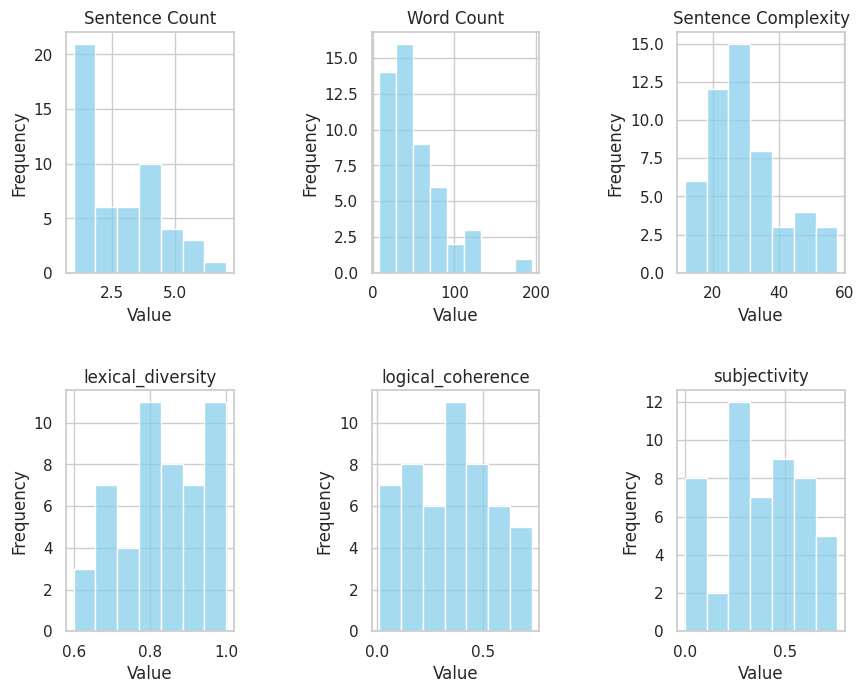

In [ ]:
# 列出要绘制直方图的列
columns_to_plot = [
     'Sentence Count', 'Word Count',
    'Sentence Complexity',
    'lexical_diversity',
    'logical_coherence', 'subjectivity'
]


plot_histograms(df_high_quality1,columns_to_plot)

In [ ]:
plot_histograms(df_low_quality1,columns_to_plot)
plot_boxplots(df_high_quality1,columns_to_plot)

NameError: name 'plot_histograms' is not defined

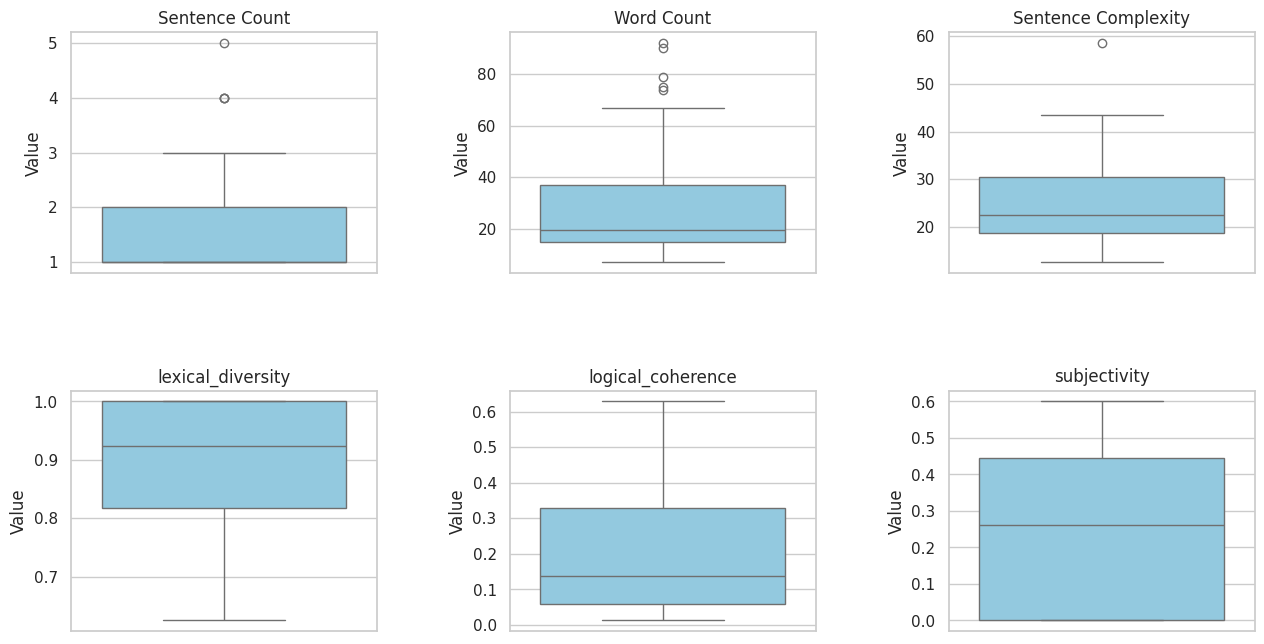

In [ ]:
plot_boxplots(df_low_quality1,columns_to_plot)

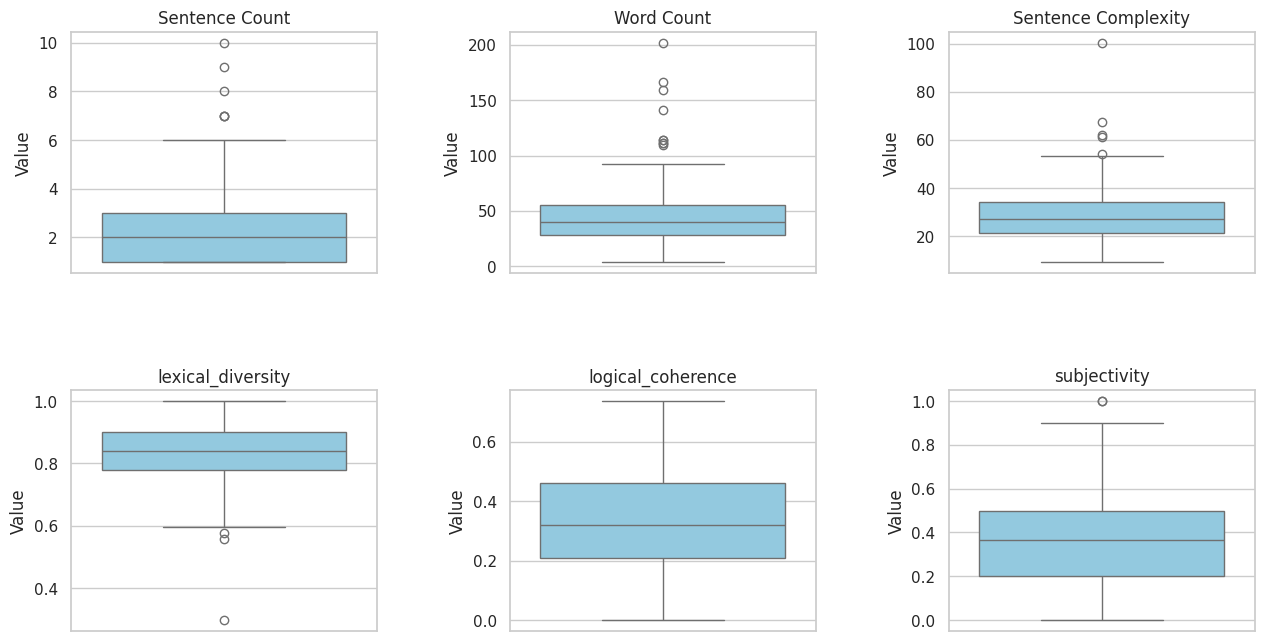

In [ ]:
plot_boxplots(df_medium_quality1,columns_to_plot)

In [ ]:
pd.set_option('display.max_columns', None)
df_golden

,id,observation text,safe/unsafe,safe/unsafe_x,safe/unsafe_y,act/condition,act/condition_x,act/condition_y,name,comments from annotator,hazard_labels_x,hazard_labels_y,hazard_labels,lsr_labels_x,lsr_labels_y,lsr_labels,barrier_labels_x,barrier_labels_y,barrier_labels,safetype_score,barriertype_score,comments_score,hazard_labels_score,lsr_labels_score,barrier_labels_score,overall_score,quality_type,binary_hazard_labels_score,binary_lsr_labels_score,binary_barrier_labels_score,Tokenized,PoS_tagged,Tokenized without stop words,NOUN,VERB,ADJ,ADV,Sentence Count,Word Count,Sentence Complexity,Readability,grammar_accuracy,lexical_diversity,spelling_errors,perplexity,logical_coherence,subjectivity,quality_type_encoded,similarity_scores_hazard,similarity_scores_lsr,similarity_scores_barrier,similarity_score_TFIDF_lsr,similarity_score_TFIDF_barrier,similarity_score_TFIDF_hazard,predicted_lsr,predicted_hazard,predicted_barrier,is_match_lsr,is_match_hazard,is_match_barrier
0,OC-00004734,"Whilst answering natures call, it became apparent that the Toilet was bloked causing a serious Hygiene issue,",[Unsafe],[Unsafe],[Unsafe],[Condition],[Condition],[Condition],"['Al', 'Ma']","[Depending on the circumstances, this is not really a safety report. It is a facilities management helpdesk call tha...","[Human Factors, Biological, Environment]",[Biological],"[Biological, Environment, Human Factors]",[],[],[],[],[Inspections],[Inspections],1,1,1,1.00,0.00,0.5,0.3250,low quality,1,0,0,"[whilst, answering, natures, call, it, became, apparent, that, the, toilet, was, bloked, causing, a, serious, hygien...","[(whilst, SCONJ), (answering, VERB), (natures, NOUN), (call, VERB), (,, PUNCT), (it, PRON), (became, VERB), (apparen...","[whilst, answering, natures, apparent, toilet, bloked, causing, hygiene, issue]",4,5,2,0,1,19,24.894737,11.1,1,1.000000,1.0,6.471247,0.154530,0.338889,1,0.805287,0.806797,0.822009,0.014944,0.039851,0.144887,Line of Fire,Biological,Inspections,0,1,1
1,OC-00005008,During preparation works to change the supply for the accommodation services switch board it was noted that the TR A...,"[Unsafe, Safe]",[Unsafe],[Safe],"[Act, Condition]",[Act],[Condition],"['Al', 'Gu']",[],"[Human Factors, Biological]",[Biological],"[Biological, Human Factors]","[Line of Fire, Work Authorisation]",[Bypassing Safety Control],"[Bypassing Safety Control, Line of Fire, Work Authorisation]",[],"[Following Procedures, Protection Systems]","[Following Procedures, Protection Systems]",0,0,0,1.00,0.75,0.5,0.3375,low quality,1,0,0,"[during, preparation, works, to, change, the, supply, for, the, accommodation, services, switch, board, it, was, not...","[(during, ADP), (preparation, NOUN), (works, NOUN), (to, PART), (change, VERB), (the, DET), (supply, NOUN), (for, AD...","[preparation, works, change, supply, accommodation, services, switch, board, noted, tr, ahu, need, configured, recir...",21,10,1,0,2,71,45.260563,15.6,2,0.782609,4.0,2.156643,0.463684,0.375000,1,0.804305,0.798378,0.814693,0.047647,0.092986,0.223825,Bypassing Safety Control,Biological,Protection Systems,1,1,1
2,OC-00005735,Good use of barriers to restrict access into work area where radiography was being carried out.,[Safe],[Safe],[Safe],[Act],[Act],[Act],"['Ro', 'An']",[Work control - restricted access],[],[Radiation],[Radiation],[],[Work Authorisation],[Work Authorisation],[],"[Inspections, Following Procedures]","[Following Procedures, Inspections]",1,1,1,0.50,0.50,0.5,0.3250,low quality,0,0,0,"[use, of, barriers, to, restrict, access, into, area, where, radiography, was, being, carried, out]","[(good, ADJ), (use, NOUN), (of, ADP), (barriers, NOUN), (to, PART), (restrict, VERB), (access, NOUN), (into, ADP), (...","[use, barriers, restrict, access, area, radiography, carried]",6,2,1,0,1,17,23.705882,10.7,0,1.000000,0.0,8.429167,0.118636,0.600000,1,0.777841,0.792183,0.782826,0.222163,0.207143,0.174811,Line of Fire,Radiation,Following Procedures,0,1,1
3,OC-00006026,Observed team member de-canting 

#3. Quality score formual
##3.1 Linear regression

In [ ]:

import numpy as np
from scipy.optimize import minimize
from scipy.stats import pearsonr

# 收集所有变量
x1 = np.array(df_golden['NOUN'])
x2 = np.array(df_golden['VERB'])
x3 = np.array(df_golden['ADJ'])
x4 = np.array(df_golden['ADV'])
x5 = np.array(df_golden['Sentence Count'])
x6 = np.array(df_golden['Word Count'])
x7 = np.array(df_golden['Sentence Complexity'])
x8 = np.array(df_golden['Readability'])
x9 = np.array(df_golden['grammar_accuracy'])
x10 = np.array(df_golden['lexical_diversity'])
x11 = np.array(df_golden['spelling_errors'])
x12 = np.array(df_golden['perplexity'])
x13 = np.array(df_golden['logical_coherence'])
x14 = np.array(df_golden['subjectivity'])
x15 = np.array(df_golden['similarity_score_TFIDF_lsr'])
x16 = np.array(df_golden['similarity_score_TFIDF_barrier'])
x17 = np.array(df_golden['similarity_score_TFIDF_hazard'])

# Overall score (目标值)
overall_score = np.array(df_golden['overall_score'])

# 定义质量得分计算公式
def quality_score(weights, *features):
    return np.dot(weights, features)

# 定义目标函数: 最小化 quality_score 和 overall_score 之间的 MSE
def objective_function(weights, *features, overall_score):
    predicted_score = quality_score(weights, *features)
    mse = np.mean((predicted_score - overall_score) ** 2)
    return mse

# 包装函数，用于传递 overall_score
def wrapped_objective_function(weights, *features):
    return objective_function(weights, *features, overall_score=overall_score)

# 收集所有特征
features = (x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17)

# 初始化权重
initial_weights = np.ones(len(features))

# 使用优化算法最小化目标函数
result = minimize(wrapped_objective_function, initial_weights, args=features, method='BFGS')

# 最优权重
optimal_weights = result.x

# 计算最优权重下的质量得分
final_quality_scores = quality_score(optimal_weights, *features)

# 计算最终质量得分与 overall_score 的相关性
correlation, _ = pearsonr(final_quality_scores, overall_score)

print(f"Optimal weights: {optimal_weights}")
print(f"Correlation between quality score and overall score: {correlation}")


Optimal weights: [ 3.20408541e-03  1.25332191e-02  1.87822832e-02  2.93434913e-03
  4.50757572e-02 -6.53786398e-03  8.14695488e-03 -7.27546057e-03
 -9.96557832e-03  2.55321687e-01  2.75592058e-04  4.04340543e-04
  3.38311421e-01  2.00813510e-01  7.84825991e-01  2.81347240e-01
  1.93405223e-01]
Correlation between quality score and overall score: 0.3812874636725632


In [ ]:
features = [
    'NOUN', 'VERB', 'ADJ', 'ADV', 'Sentence Count', 'Word Count',
    'Sentence Complexity', 'Readability', 'grammar_accuracy', 'lexical_diversity',
    'spelling_errors', 'perplexity', 'logical_coherence', 'subjectivity',
    'similarity_score_TFIDF_lsr', 'similarity_score_TFIDF_barrier', 'similarity_score_TFIDF_hazard'
]

# 提供的最优权重
optimal_weights = np.array([
    3.20408541e-03, 1.25332191e-02, 1.87822832e-02, 2.93434913e-03,
    4.50757572e-02, -6.53786398e-03, 8.14695488e-03, -7.27546057e-03,
    -9.96557832e-03, 2.55321687e-01, 2.75592058e-04, 4.04340543e-04,
    3.38311421e-01, 2.00813510e-01, 7.84825991e-01, 2.81347240e-01,
    1.93405223e-01
])
# 确保 DataFrame 包含所有需要的特征列
for feature in features:
    if feature not in df_golden.columns:
        raise ValueError(f"Missing feature column: {feature}")

# 计算质量得分
df_golden['Predicted_quality_score'] = (
    df_golden[features].values @ optimal_weights
)



In [ ]:
# 将 features 和 optimal_weights 放入 DataFrame 中
df_feature_weight = pd.DataFrame({
    'Feature': features,
    'Weight': optimal_weights
})

# 按照 Weight 列从大到小排序
sorted_df_feature_weight = df_feature_weight.sort_values(by='Weight', ascending=False)

# 显示排序后的 DataFrame
print(sorted_df_feature_weight)

                           Feature    Weight
14      similarity_score_TFIDF_lsr  0.784826
12               logical_coherence  0.338311
15  similarity_score_TFIDF_barrier  0.281347
9                lexical_diversity  0.255322
13                    subjectivity  0.200814
16   similarity_score_TFIDF_hazard  0.193405
4                   Sentence Count  0.045076
2                              ADJ  0.018782
1                             VERB  0.012533
6              Sentence Complexity  0.008147
0                             NOUN  0.003204
3                              ADV  0.002934
11                      perplexity  0.000404
10                 spelling_errors  0.000276
5                       Word Count -0.006538
7                      Readability -0.007275
8                 grammar_accuracy -0.009966


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score

# 定义函数来计算 Accuracy 和 Recall
def calculate_metrics(threshold, df, true_labels):
    # 根据当前阈值计算预测标签
    predicted_labels = (df['Predicted_quality_score'] < threshold).astype(int)

    # 计算准确率和召回率
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    roc_auc = roc_auc_score(true_labels, predicted_labels)

    return accuracy, recall, roc_auc

# 遍历不同的阈值，找到最优的阈值
best_threshold = None
best_accuracy = 0
best_recall = 0
best_roc_auc = 0

true_labels = df_golden['comments_score']  # 真实标签

thresholds = np.linspace(0, 1, 100)  # 生成0到1之间的100个候选阈值
for threshold in thresholds:
    accuracy, recall, roc_auc = calculate_metrics(threshold, df_golden, true_labels)

    # 找到最优的阈值，这里你可以根据自己的需求来定义最优的标准
    # 例如，如果你想同时优化 accuracy 和 recall，你可以计算两者的加权和
    # if (accuracy + recall) > (best_accuracy + best_recall):
    #     best_threshold = threshold
    #     best_accuracy = accuracy
    #     best_recall = recall
    #     best_roc_auc = roc_auc
    # if accuracy  > best_accuracy :
    #     best_threshold = threshold
    #     best_accuracy = accuracy
    #     best_recall = recall
    #     best_roc_auc = roc_auc
    if roc_auc  > best_roc_auc :
        best_threshold = threshold
        best_recall = recall
        best_accuracy = accuracy
        best_roc_auc = roc_auc
    # if recall  > best_recall :
    #     best_threshold = threshold
    #     best_accuracy = accuracy
    #     best_recall = recall
    #     best_roc_auc = roc_auc


# 打印最优阈值及其对应的准确率和召回率
print(f"Best threshold: {best_threshold}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Best Recall: {best_recall:.4f}")
print(f"best roc_auc: {best_roc_auc:.4f}")

# 使用找到的最佳阈值更新 predicted_quality_label
# df_golden['predicted_quality_label'] = (df_golden['Predicted_quality_score'] < best_threshold).astype(int)

Best threshold: 0.7070707070707072
Best Accuracy: 0.6033
Best Recall: 0.8077
best roc_auc: 0.6841


In [ ]:
z = np.linspace(0, 1, 100)
z

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [ ]:
# 输出文件
# df_golden
# df_golden.to_csv('/content/drive/My Drive/Dissertation/df_golden_test_validation.csv', index=False)

In [ ]:
# 显示计算结果
# print(df_golden[['Predicted_quality_score']].head())
(df_golden['Predicted_quality_score'] >=0.83)

df_golden['predicted_quality_label'] = (df_golden['Predicted_quality_score'] < 0.58).astype(int)
df_golden
(df_golden['Predicted_quality_score'] < 0.58).sum()

In [ ]:
df_golden

,id,observation text,safe/unsafe,safe/unsafe_x,safe/unsafe_y,act/condition,act/condition_x,act/condition_y,name,comments from annotator,hazard_labels_x,hazard_labels_y,hazard_labels,lsr_labels_x,lsr_labels_y,lsr_labels,barrier_labels_x,barrier_labels_y,barrier_labels,safetype_score,barriertype_score,comments_score,hazard_labels_score,lsr_labels_score,barrier_labels_score,overall_score,quality_type,binary_hazard_labels_score,binary_lsr_labels_score,binary_barrier_labels_score,Tokenized,PoS_tagged,Tokenized without stop words,NOUN,VERB,ADJ,ADV,Sentence Count,Word Count,Sentence Complexity,Readability,grammar_accuracy,lexical_diversity,spelling_errors,perplexity,logical_coherence,subjectivity,quality_type_encoded,similarity_scores_hazard,similarity_scores_lsr,similarity_scores_barrier,similarity_score_TFIDF_lsr,similarity_score_TFIDF_barrier,similarity_score_TFIDF_hazard,predicted_lsr,predicted_hazard,predicted_barrier,is_match_lsr,is_match_hazard,is_match_barrier,Predicted_quality_score,predicted_quality_label
0,OC-00004734,"Whilst answering natures call, it became apparent that the Toilet was bloked causing a serious Hygiene issue,",[Unsafe],[Unsafe],[Unsafe],[Condition],[Condition],[Condition],"['Al', 'Ma']","[Depending on the circumstances, this is not really a safety report. It is a facilities management helpdesk call tha...","[Human Factors, Biological, Environment]",[Biological],"[Biological, Environment, Human Factors]",[],[],[],[],[Inspections],[Inspections],1,1,1,1.00,0.00,0.5,0.3250,low quality,1,0,0,"[whilst, answering, natures, call, it, became, apparent, that, the, toilet, was, bloked, causing, a, serious, hygien...","[(whilst, SCONJ), (answering, VERB), (natures, NOUN), (call, VERB), (,, PUNCT), (it, PRON), (became, VERB), (apparen...","[whilst, answering, natures, apparent, toilet, bloked, causing, hygiene, issue]",4,5,2,0,1,19,24.894737,11.1,1,1.000000,1.0,6.471247,0.154530,0.338889,1,0.805287,0.806797,0.822009,0.014944,0.039851,0.144887,Line of Fire,Biological,Inspections,0,1,1,0.575505,1
1,OC-00005008,During preparation works to change the supply for the accommodation services switch board it was noted that the TR A...,"[Unsafe, Safe]",[Unsafe],[Safe],"[Act, Condition]",[Act],[Condition],"['Al', 'Gu']",[],"[Human Factors, Biological]",[Biological],"[Biological, Human Factors]","[Line of Fire, Work Authorisation]",[Bypassing Safety Control],"[Work Authorisation, Bypassing Safety Control, Line of Fire]",[],"[Following Procedures, Protection Systems]","[Following Procedures, Protection Systems]",0,0,0,1.00,0.75,0.5,0.3375,low quality,1,0,0,"[during, preparation, works, to, change, the, supply, for, the, accommodation, services, switch, board, it, was, not...","[(during, ADP), (preparation, NOUN), (works, NOUN), (to, PART), (change, VERB), (the, DET), (supply, NOUN), (for, AD...","[preparation, works, change, supply, accommodation, services, switch, board, noted, tr, ahu, need, configured, recir...",21,10,1,0,2,71,45.260563,15.6,2,0.782609,4.0,2.156643,0.463684,0.375000,1,0.804305,0.798378,0.814693,0.047647,0.092986,0.223825,Bypassing Safety Control,Biological,Protection Systems,1,1,1,0.613481,0
2,OC-00005735,Good use of barriers to restrict access into work area where radiography was being carried out.,[Safe],[Safe],[Safe],[Act],[Act],[Act],"['Ro', 'An']",[Work control - restricted access],[],[Radiation],[Radiation],[],[Work Authorisation],[Work Authorisation],[],"[Inspections, Following Procedures]","[Inspections, Following Procedures]",1,1,1,0.50,0.50,0.5,0.3250,low quality,0,0,0,"[use, of, barriers, to, restrict, access, into, area, where, radiography, was, being, carried, out]","[(good, ADJ), (use, NOUN), (of, ADP), (barriers, NOUN), (to, PART), (restrict, VERB), (access, NOUN), (into, ADP), (...","[use, barriers, restrict, access, area, radiography, carried]",6,2,1,0,1,17,23.705882,10.7,0,1.000000,0.0,8.429167,0.118636,0.600000,1,0.777841,0.792183,0.782825,0.222163,0.207143,0.174811,Line of Fire,Radiation,Fol

##3.3Random forest regression

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

# 假设 df_golden 已经存在并包含所有特征
# 收集所有特征变量
features_randomforest = df_golden[['NOUN', 'VERB', 'ADJ', 'ADV', 'Sentence Count', 'Word Count',
                      'Sentence Complexity', 'Readability', 'grammar_accuracy',
                      'lexical_diversity', 'spelling_errors', 'perplexity',
                      'logical_coherence', 'subjectivity', 'similarity_score_TFIDF_lsr',
                      'similarity_score_TFIDF_barrier', 'similarity_score_TFIDF_hazard']]

# 目标变量：overall_score
overall_score_randomforest = df_golden['overall_score']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features_randomforest, overall_score_randomforest, test_size=0.2, random_state=42)

# 创建随机森林回归模型
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# 训练模型
rf.fit(X_train, y_train)

# 进行预测
y_pred = rf.predict(X_test)

# 计算均方误差
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# 获取特征重要性
feature_importances = rf.feature_importances_

# 将特征名称与重要性值配对
feature_importance_df = pd.DataFrame({
    'Feature': features_randomforest.columns,
    'Importance': feature_importances
})

# 按照重要性排序
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 输出特征重要性
print(feature_importance_df)

# 计算预测结果与 overall_score 之间的相关性
correlation, _ = pearsonr(y_pred, y_test)
print(f"Correlation between predicted quality score and overall score: {correlation}")


Mean Squared Error: 0.1008575955572917
                           Feature  Importance
14      similarity_score_TFIDF_lsr    0.133277
5                       Word Count    0.120668
7                      Readability    0.098175
16   similarity_score_TFIDF_hazard    0.081772
12               logical_coherence    0.074668
15  similarity_score_TFIDF_barrier    0.071038
13                    subjectivity    0.059016
6              Sentence Complexity    0.058156
0                             NOUN    0.056116
8                 grammar_accuracy    0.046346
11                      perplexity    0.046079
2                              ADJ    0.039788
9                lexical_diversity    0.033111
1                             VERB    0.026685
10                 spelling_errors    0.024534
3                              ADV    0.023500
4                   Sentence Count    0.007072
Correlation between predicted quality score and overall score: 0.3131579578072844
